# Toward better predictions of militarized inter-state disputes

### Aim

The aim in this notebook is to predict the occurrences of militarized inter-state disputes (MIDs) between states using some of the most common machine learning algorithms. MIDs are conflicts in which one or more states threaten, display, or use force against one or more other states. Thus, not only do they include instances of interstate wars, but also cases in which there was a credible threat to use militaristic means, or in which military force was actually used without culminating to war. This notebook includes the python code used to fine-tune and compare the performance of as many of the supervised-learning algorithms as time and my laptop's computing resources have allowed. For future work, I hope to re-run an expanded version of the analysis done here on the cloud. 

### Data

- The dataset includes some data on inter-state relations covering the period 1816-2009. 
- Each sample (row) represents the relationship between two nation-states of the international system in a given year. This relationship is undirected, meaning that for each pair of states in a given year, there is only one record. Thus, the variable capturing the occurrence of a MID reflects whether or not a militarized conflict has erupted between a given pair in a given year. It doesn't reflect which side of the dyad has initiated the conflict.
- As standard in the study of MIDs, the dataset only includes instances of MID initiations. Thus, the data doesn't include the later years of an ongoing conflict for the MIDs that lasted over more than single year. This is so because it's believed that the causes of MIDs' initiation are different from those of its perpetuation. 
- As also standard in the study of MIDs, the predictor variables are lagging by one year behind the output of interest. This is done in order to reduce the risk of reverse causality (e.g. a state experiencing a MID in a given year might increase its military spending as a result. Thus, the latter's value in the same year cannot be used to predict the former).  


### Algorithms 

- The following list of supervised-learning algorithms is considered: Logistic regression, naive Bayes, decision trees, random forests, gradient boosted decision trees, linear support vector classifiers, and deep neural networks. Originally, I intended to also consider two additional algorithms: Nearest neighbors and the Kernalized version of the support vector machines. But as it turned out during the initial tinkering phase, both algorithms were awfully slow to apply to the dataset at hand.
- With the exception of Gaussian naive bayes, each of the algorithms considered here has one important parameter that will be fine-tuned. Thus, and in order to minimize the risk of overfitting, the data will be split into a training and test sets. The fine-tuning processes will be carried-out on the training set using Grid Search with cross-validation. The predictive performance of the best model of each algorithm (as identified by the cross-validated Grid Search) will then be evaluated against the test set. 
- In order to keep things computationally manageable, I only attempt to fine-tune one parameter for each algorithm. The chosen parameters are the important ones suggested by Müller and Guido (2017, chapter 2)\*. Specifically for:
        - Decision tree & Random forests: maximum tree depth
        - Logistic regression and Linear SVC: regularization parameter (C)
        - Gradient boosted decision trees: learning rate
        - Deep neural networks: number and sizes of hidden layers
 

### Evaluation metrics

- I principally use the __area under the Receiver Operating Characteristic (ROC) curve__ as the evaluation metric to optimize the different algorithms.  This is a suitable metric, I believe, because the data is highly imbalanced (the output variable 'mid_leading' is equal to one in less than 0.4% of the samples). 
- In the later parts of the analysis, I consider the effects of changing the decision threshold of the best performing models. To that end, I'll also use two additional metrics: the __Youden's J statistic__ (which captures the tradeoff between TPR and FPR) and the __f1-score__ (which captures the tradeoff between precision and recall).

### On parallel GridSearch

Naturally, running the Grid Search process in parallel (using the n_jobs option) is advantageous. Unfortunately, on my laptop (which runs Windows 7 Enterprise), any value other than one for the n_jobs option produces an error. After some investigation, it turned out that the issue is Windows-related (see https://joblib.readthedocs.io/en/latest/parallel.html), and it can be fixed by restructuring the code as follows :
   
    import ....

    def function1(...):
        ...

    def function2(...):
        ...

    ...
    if __name__ == '__main__':
        # do stuff with imports and functions defined about
        ...

This restructuring makes the n_jobs option work, but it doesn't enable the interactive manipulation of the code and data in separate inputs (because each function in the above solution has to be in the same input). Thus, I have written two notebooks. In the notebook herein, I have kept the code into separate inputs just the way I did during developing the code. The second notebook (in a file called __n_jobs_fix.ipynb__) includes a virtually identical code, but one that is re-organized according to the above structure in order to make the n_jobs option of GridSearchCV work.

### To re-do the optimization
The Grid Search optimization process reads and stores the output from and into the file, _results.csv_. If you want to re-do the Grid search optimization process from scratch, please delete the results.csv file.

-----------------------------------------------------------------------------------------------------
*Müller, Andreas C. and Sarah Guido. “Supervised Learning.” Chapter 2 (pages 25-69) in Introduction to Machine Learning with Python: A Guide for Data Scientists, O'Reilly Media, Inc.




#### Notebook by Tarek Oraby (tarek.oraby@gmail.com)

In [1]:
# reset variables
%reset -f

In [2]:
# all imports necessary for this notebook
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
random.seed(12345)
np.random.seed(12345)

In [4]:
df = pd.read_csv('data/conflicts_dataset.zip')

In [5]:
# check no missing values exist
if df.isnull().values.any():
    print("Warning!! Some missing values were found in the input data")

In [6]:
print("Dataset includes %d rows and %d features"% df.shape)

Dataset includes 641381 rows and 35 features


In [7]:
print("Dataset includes the following features:\n" , df.columns.values, sep='')

Dataset includes the following features:
['year' 'ccode_1' 'ccode_2' 'stateabb_1' 'stateabb_2' 'statenme_1'
 'statenme_2' 'mid_leading' 'disno_leading' 'cinc_1' 'polity2_1'
 'cont_total_1' 'cont_land_1' 'cont_sea_1' 'colcont_total_1'
 'colcont_land_1' 'colcont_sea_1' 'cinc_2' 'polity2_2' 'cont_total_2'
 'cont_land_2' 'cont_sea_2' 'colcont_total_2' 'colcont_land_2'
 'colcont_sea_2' 'contig' 'colcont' 'defense' 'neutrality' 'nonaggression'
 'entente' 'rlregion' 'region1' 'region2' 'distance']


In [8]:
df.head()

,year,ccode_1,ccode_2,stateabb_1,stateabb_2,statenme_1,statenme_2,mid_leading,disno_leading,cinc_1,...,contig,colcont,defense,neutrality,nonaggression,entente,rlregion,region1,region2,distance
0,1920,2,20,USA,CAN,United States of America,Canada,0,-9,0.289566,...,1,1,0,0,0,0,5,5,5,0
1,1921,2,20,USA,CAN,United States of America,Canada,0,-9,0.253229,...,1,1,0,0,0,0,5,5,5,0
2,1922,2,20,USA,CAN,United States of America,Canada,0,-9,0.255595,...,1,1,0,0,0,0,5,5,5,0
3,1923,2,20,USA,CAN,United States of America,Canada,0,-9,0.272078,...,1,1,0,0,0,0,5,5,5,0
4,1924,2,20,USA,CAN,United States of America,Canada,0,-9,0.253591,...,1,1,0,0,0,0,5,5,5,0


In [9]:
print("The dependent variable 'mid_leading' has the following distribution:\n" ,df['mid_leading'].value_counts(), sep='')
peacful_percentage = df['mid_leading'].value_counts(normalize=True)[0] * 100
print("\nWhich means that %.2f%% of the state-pairs in the dataset are (thankfully) not in conflict with one another" %  peacful_percentage)

The dependent variable 'mid_leading' has the following distribution:
0    638912
1      2469
Name: mid_leading, dtype: int64

Which means that 99.62% of the state-pairs in the dataset are (thankfully) not in conflict with one anothers


In [10]:
# The first seven featues in the dataset (i.e., year, ccode_1, ccode_2, stateabb_1, stateabb_2, statenme_1, statenme_2) are 
# identifications that are unlikely to help in obtaining a general predictor of conflict between states. Accordingly these
# will be excluded from the analysis.

# Take the features from 'cinc_1' to 'distance' in a separate array as the predictors of the output (mid_leading)
x_array = df.loc[:, 'cinc_1':'distance'].values

In [11]:
# Rescale features of x_array to fall between 0-1 because some algorithms (e.g. SVM) yield better performance after rescaling
scaler = MinMaxScaler()
scaler.fit(x_array)
x_array = scaler.transform(x_array)

In [12]:
# Split data into a training and test set, the former will be used for Grid Search with cross-validation
X_train, X_test, y_train, y_test = train_test_split(x_array, df['mid_leading'], stratify=df['mid_leading'], shuffle=True,  test_size=0.25)

In [13]:
# The following defines the search space for each algorithm
# I generally consider more values for faster algorithms (e.g. decision trees) relative to slower ones (e.g. Linear SVC).
# The exception to this is the MLPClassifier, for which I explore a bunch of values despite being relatively slow.

search_space = [['GaussianNB', {}], # GaussianNB has no important parameter to fine-tune (it has a decision threshold which will be considered later). It's included here just for reference.
                ['DecisionTreeClassifier', {'max_depth': [4, 6, 8, 12, 14, 16, 18]}],
                ['RandomForestClassifier', {'max_depth': [4, 6, 8, 12]}],                
                ['LogisticRegression', {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
                ['LinearSVC', {'C': [0.001, 1,  100]}],
                ['GradientBoostingClassifier', {'learning_rate': [0.001, 1,  100]}],
                ['MLPClassifier', {'hidden_layer_sizes': [[100, 100],
                                                          [30, 30, 30, 30],
                                                          [60, 20, 10],
                                                          [10, 10, 10, 10, 10, 10, 10]]}]]


In [14]:
labels = ['classifier', 'parameter_grid']
results = pd.DataFrame.from_records(search_space, columns=labels)
### add columns to hold the results
results['processed'] = False
results['best_parameter'] = None
results['test_score'] = None
results['mean_crossVal_score'] = None
results['mean_crossVal_fit_time'] = None
results['mean_crossVal_score_time'] = None
results['best_estimator_settings_all'] = None
results['evaluation_metric'] = 'roc_auc' # inclded just in case there is a need in the future to optimize on a different metric
results


,classifier,parameter_grid,processed,best_parameter,test_score,mean_crossVal_score,mean_crossVal_fit_time,mean_crossVal_score_time,best_estimator_settings_all,evaluation_metric
0,GaussianNB,{},False,None,None,None,None,None,None,roc_auc
1,DecisionTreeClassifier,"{'max_depth': [4, 6, 8, 12, 14, 16, 18]}",False,None,None,None,None,None,None,roc_auc
2,RandomForestClassifier,"{'max_depth': [4, 6, 8, 12]}",False,None,None,None,None,None,None,roc_auc
3,LogisticRegression,"{'C': [0.001, 0.01, 0.1, 1, 10, 100]}",False,None,None,None,None,None,None,roc_auc
4,LinearSVC,"{'C': [0.001, 1, 100]}",False,None,None,None,None,None,None,roc_auc
5,GradientBoostingClassifier,"{'learning_rate': [0.001, 1, 100]}",False,None,None,None,None,None,None,roc_auc
6,MLPClassifier,"{'hidden_layer_sizes': [[100, 100], [30, 30, 3...",False,None,None,None,None,None,None,roc_auc


# On the coding strategy of Grid Search

Given the time-consuming nature of grid search, and in order to avoid losing the search results that has been already obtained in case of an unexpected error or a computer crash, I coded the Grid search so that it saves the results directly to file and to check that file before it starts optimizing a new classifier. 

In [15]:
# only create a results.csv file if one doesn't already exist
try:
    # start by reading the results.csv file 
    results = pd.read_csv('results.csv')
except:
    results.to_csv('results.csv', index = False)
    

In [16]:
# This method checks the results file to see if a classifier has already been processed.
def classifier_processed(classifier_name, results):
    if (results['processed'][results['classifier'] == classifier_name].iloc[0] == True):  
        return True
    else:
        return False

In [17]:
# This method prints the results of optimization
def print_results(classifier_string, results):
    best_param = results.loc[results['classifier'] == classifier_string, ['best_parameter']].iloc[0].values[0]
    mean_crossVal_score = results.loc[results['classifier'] == classifier_string, ['mean_crossVal_score']].iloc[0].values[0]
    test_score = results.loc[results['classifier'] == classifier_string, ['test_score']].iloc[0].values[0]
    print("Best parameter: " + str(best_param))
    print("Mean cross-validation score of best: %.4f" % mean_crossVal_score)
    print("Test score of best: %.4f" %test_score)

In [18]:
# Given that the output 'mid_leading' is imbalanced, use stratfied folds with shuffling in the cross-val of the grid search
kfold = StratifiedKFold(n_splits = 4, shuffle = True)

In [19]:
print("\n\n***Start of grid search optimization based on area under ROC curve***\n\n")

for item in search_space:
    classifier_string = item[0]
    parameter_grid = item[1]
    
    # check the results file if this classifier has already been processed
    if classifier_processed(classifier_string, results):
        print(classifier_string + " is already optimized, with the following results \n")
        print_results(classifier_string, results)
        print("\n\n\n")
        continue
        
    print("Working on optimizing: " + classifier_string)
    print("Using the following parameter grid: " + str(parameter_grid) + "\n")
    
    classifier = eval(classifier_string + '''()''')
    
    grid_search = GridSearchCV(classifier, parameter_grid, cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=10)
    grid_search.fit(X_train, y_train)
    
    test_score = None
    predictions_of_best = None
    if hasattr(classifier, 'predict_proba'):
        predictions_of_best = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        test_score = roc_auc_score(y_test,  predictions_of_best)
    elif hasattr(classifier, 'decision_function'):
        predictions_of_best = grid_search.best_estimator_.decision_function(X_test)
        test_score = roc_auc_score(y_test,  predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
    
        
    # update the results datadrame & file
    results.loc[results['classifier'] == classifier_string, ['processed']] = True
    results.loc[results['classifier'] == classifier_string, ['best_parameter']] = str(grid_search.best_params_)
    results.loc[results['classifier'] == classifier_string, ['test_score']] = test_score
    results.loc[results['classifier'] == classifier_string, ['mean_crossVal_score']] = grid_search.best_score_
    results.loc[results['classifier'] == classifier_string, ['mean_crossVal_fit_time']] = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
    results.loc[results['classifier'] == classifier_string, ['mean_crossVal_score_time']] = grid_search.cv_results_['mean_score_time'][grid_search.best_index_]
    results.loc[results['classifier'] == classifier_string, ['best_estimator_settings_all']] = str(grid_search.best_estimator_)
    
    # print results of best
    print("\n\nOptimization Results of " + classifier_string + ":")
    print_results(classifier_string, results)
    
    # save results of best to file
    results.to_csv('results.csv', index = False)
    
    # save trained best model to file
    joblib.dump(grid_search.best_estimator_, classifier_string + '.pkl') 
    
    print(80 * "-")
    



***Start of grid search optimization based on area under ROC curve***


GaussianNB is already optimized, with the following results 

Best parameter: {}
Mean cross-validation score of best: 0.8923
Test score of best: 0.8852




DecisionTreeClassifier is already optimized, with the following results 

Best parameter: {'max_depth': 6}
Mean cross-validation score of best: 0.9034
Test score of best: 0.8800




RandomForestClassifier is already optimized, with the following results 

Best parameter: {'max_depth': 12}
Mean cross-validation score of best: 0.9482
Test score of best: 0.9524




LogisticRegression is already optimized, with the following results 

Best parameter: {'C': 0.1}
Mean cross-validation score of best: 0.9181
Test score of best: 0.9077




LinearSVC is already optimized, with the following results 

Best parameter: {'C': 1}
Mean cross-validation score of best: 0.9139
Test score of best: 0.9054




GradientBoostingClassifier is already optimized, with the following resu

In [20]:
print('\nBased on the area under the ROC curve, the best parameters for the optimized algorithms are as follows\n')
print(results[['classifier', 'best_parameter']])
print(80 * "-")


Based on the area under the ROC curve, the best parameters for the optimized algorithms are as follows

                   classifier                        best_parameter
0                  GaussianNB                                    {}
1      DecisionTreeClassifier                      {'max_depth': 6}
2      RandomForestClassifier                     {'max_depth': 12}
3          LogisticRegression                            {'C': 0.1}
4                   LinearSVC                              {'C': 1}
5  GradientBoostingClassifier              {'learning_rate': 0.001}
6               MLPClassifier  {'hidden_layer_sizes': [60, 20, 10]}
--------------------------------------------------------------------------------


In [21]:
print('\nThe mean cross-val and test scores for the optimized algorithms are as follows (sorted by mean_crossVal_score)\n')
print(results[['classifier', 'mean_crossVal_score', 'test_score' ]].sort_values(by = ['mean_crossVal_score'], ascending=False))
print(80 * "-")


The mean cross-val and test scores for the optimized algorithms are as follows (sorted by mean_crossVal_score)

                   classifier  mean_crossVal_score  test_score
2      RandomForestClassifier             0.948244    0.952418
6               MLPClassifier             0.947070    0.950321
3          LogisticRegression             0.918104    0.907723
4                   LinearSVC             0.913861    0.905424
1      DecisionTreeClassifier             0.903434    0.880003
0                  GaussianNB             0.892295    0.885231
5  GradientBoostingClassifier             0.864564    0.870072
--------------------------------------------------------------------------------


In [22]:
top_ROC_classifier = results[['classifier', 'mean_crossVal_score']].sort_values(by = ['mean_crossVal_score'], ascending=False).iloc[0][0]
top_ROC_parameter = results[['best_parameter', 'mean_crossVal_score']].sort_values(by = ['mean_crossVal_score'], ascending=False).iloc[0][0]
print('Thus, based on the training data, the ' + top_ROC_classifier + ' algorithm with the\nfollowing parameter' + str(top_ROC_parameter) + ' has the highest area under the ROC curve.')
print(80 * "-")

Thus, based on the training data, the RandomForestClassifier algorithm with the
following parameter{'max_depth': 12} has the highest area under the ROC curve.
--------------------------------------------------------------------------------


ROC curves based on training data


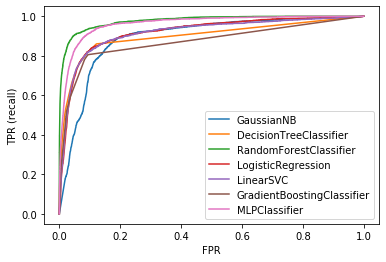

--------------------------------------------------------------------------------


In [23]:
# print ROC curves based on training data
print('ROC curves based on training data')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load(classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
        
    plt.plot(fpr, tpr, label=classifier_string)
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.legend(loc= 'lower right')
    
plt.show() 
print(80 * "-")

# Balancing TPR and FPR

Now that we know which classifiers have which ROC curves, let's focus on adjusting the decision thresholds for these classifiers. Based on the ROC curves, I think it'd be desirable to discover the threshold at which we can acheive a high TPR with an accptably low FPR. In other words, I want to find out the point on the ROC curve that would yeild the maximum value for "TPR - FPR". After googling it, the latter fomula turned out to be called __Youden's J statistic__ (https://en.wikipedia.org/wiki/Youden%27s_J_statistic). 

In [24]:
# create three new columns in the results datafame to hold the threshold at which the maximum j-score is obtained in the
# training data, as well as the values of the j-score for the training and test data 
results['j_threshold'] = None
results['j_max_train'] = None
results['j_max_test'] = None

In [25]:
# Optimizing decision thresholds based on Youden's J-statistic
print('\n\nOptimizing decision thresholds based on Youden\'s J-statistic:\n\n')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load(classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
    
    # calculate j-scores for all decision thresholds
    j_scores = tpr-fpr
    
    # Find the max j-score and its threshold
    j_ordered = sorted(zip(j_scores,thresholds))
    max_j_train = j_ordered[-1][0]
    threshold_of_max = j_ordered[-1][1]
    
    
    # Now for the test data, calculate Youden's J-Score based on the identified threshold_of_max
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_test)[:, 1]
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_test)

    predictions_of_max_test = []
    for curr_prediction in predictions_of_best:
            if curr_prediction < threshold_of_max:
                predictions_of_max_test.append(0)
            else:
                predictions_of_max_test.append(1)
    
    # Youdin's j-score is also equal to (sensitivity + specificity - 1)
    sensitivity = recall_score(y_test, predictions_of_max_test)
    specificity = recall_score(y_test, predictions_of_max_test, pos_label=0)
    max_j_test = sensitivity + specificity - 1
    
    # save to the results dataframe
    results.loc[results['classifier'] == classifier_string, ['j_max_train']] = max_j_train
    results.loc[results['classifier'] == classifier_string, ['j_max_test']] = max_j_test
    results.loc[results['classifier'] == classifier_string, ['j_threshold']] = threshold_of_max
    
    print('For the classifier ' + classifier_string)
    print('On the training data, the maximum j score is ' + str(max_j_train) + ', which was obtained using the threshold: ' + str(threshold_of_max))
    print('On the test data, and at the same threshold, the j score is ' + str(max_j_test) + ' with the following classification report:\n')
    print(classification_report(y_test,  predictions_of_max_test))
    print('and the following accuracy score ' + str(accuracy_score(y_test,  predictions_of_max_test)))
    print(80 * "-", "\n")



Optimizing decision thresholds based on Youden's J-statistic:


For the classifier GaussianNB
On the training data, the maximum j score is 0.6977952842421056, which was obtained using the threshold: 2.4091629068820417e-08
On the test data, and at the same threshold, the j score is 0.6841039198148349 with the following classification report:

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    159729
           1       0.02      0.88      0.03       617

    accuracy                           0.81    160346
   macro avg       0.51      0.84      0.46    160346
weighted avg       1.00      0.81      0.89    160346

and the following accuracy score 0.8091564491786511
-------------------------------------------------------------------------------- 

For the classifier DecisionTreeClassifier
On the training data, the maximum j score is 0.7381017829803355, which was obtained using the threshold: 0.005711659663865546
On the test data, and at

In [26]:
top_j_classifier = results[['classifier', 'j_max_train']].sort_values(by = ['j_max_train'], ascending=False).iloc[0][0]
print('Thus, based on the training data, the ' + top_j_classifier + ' algorithm has the highest maximum Youden\'s J-statistic, which means that it has the highest maximum difference betweeb TPR and FPR\n')
print(results[['classifier', 'j_max_train', 'j_max_test', 'j_threshold' ]].sort_values(by = ['j_max_train'], ascending=False))
print(80 * "-")

Thus, based on the training data, the RandomForestClassifier algorithm has the highest maximum Youden's J-statistic, which means that it has the highest maximum difference betweeb TPR and FPR

                   classifier j_max_train j_max_test  j_threshold
2      RandomForestClassifier    0.856377    0.75428    0.0122957
6               MLPClassifier    0.817901   0.768378   0.00457271
1      DecisionTreeClassifier    0.738102   0.711432   0.00571166
3          LogisticRegression    0.732979   0.698904   0.00331871
4                   LinearSVC     0.72474    0.69227    -0.986037
5  GradientBoostingClassifier    0.711389   0.705269   0.00372191
0                  GaussianNB    0.697795   0.684104  2.40916e-08
--------------------------------------------------------------------------------


ROC curves with max. Youden's J-statistic, based on training data


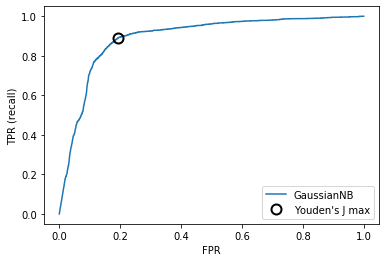

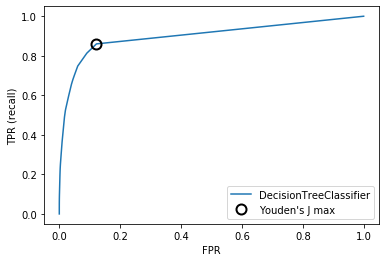

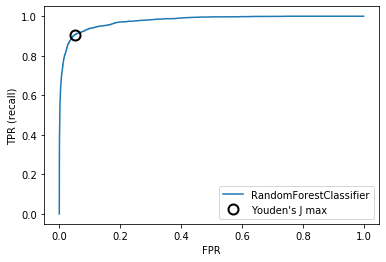

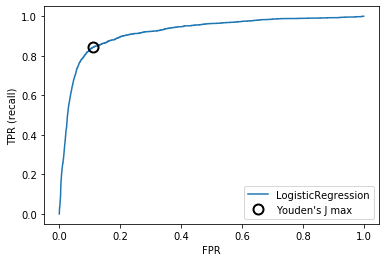

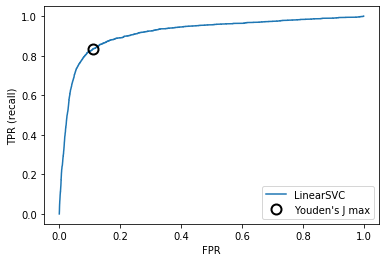

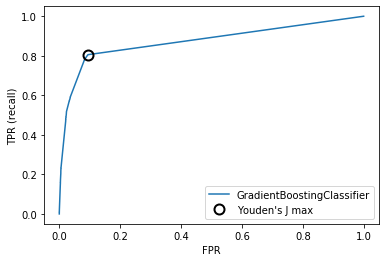

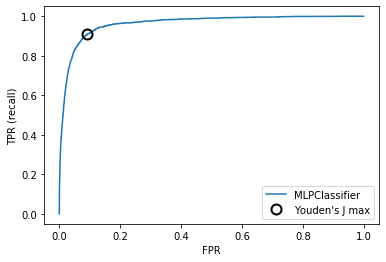

--------------------------------------------------------------------------------


In [27]:
# based on training data, print ROC curves highlighting the thresholds at which the maximum Youden's J-statistic is obtained
print('ROC curves with max. Youden\'s J-statistic, based on training data')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load(classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
        
    threshold_of_max = results.loc[results['classifier'] == classifier_string, ['j_threshold']].iloc[0][0]
    close_max_threshold = np.argmin(np.abs(thresholds - threshold_of_max))
    
    plt.plot(fpr, tpr, label=classifier_string)
    plt.plot(fpr[close_max_threshold], tpr[close_max_threshold], 'o', markersize=10,
             label=("Youden's J max"), fillstyle="none", c='k', mew=2)
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.legend(loc= 'lower right')
    plt.show()
    
print(80 * "-")

# Balancing precision and recall

Another desirable property of a classifier is to have a high degree of both precision and recall. In what follows, I seek the decision threshold for each of the identified classsifiers that would yield the maximum f1-score

In [28]:
# create three new columns in the results datafame to hold the threshold at which the maximum f1-score is obtained in the
# training data, as well as the values of the f1-score for the training and test data 
results['f1_threshold'] = None
results['f1_max_train'] = None
results['f1_max_test'] = None


In [29]:
# Optimizing decision thresholds based on the f1-score
print('\n\nOptimizing decision thresholds based on the f1-score\n\n')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load(classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        precision, recall, thresholds = precision_recall_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate precision and recall curve')
          
    max_f1_train = 0
    threshold_of_max = None
    for r, p, t in zip(recall, precision, thresholds):
        if p + r == 0: continue
        if (2*p*r)/(p + r) > max_f1_train:
            max_f1_train = (2*p*r)/(p + r) 
            threshold_of_max = t

    
    
    # Now for the test data, calculate the f1-score based on the identified threshold_of_max
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_test)[:, 1]
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_test)

    predictions_of_max_test = []
    for curr_prediction in predictions_of_best:
            if curr_prediction < threshold_of_max:
                predictions_of_max_test.append(0)
            else:
                predictions_of_max_test.append(1)
    
    max_f1_test = f1_score(y_test,  predictions_of_max_test)
    
    # save to the results dataframe
    results.loc[results['classifier'] == classifier_string, ['f1_max_train']] = max_f1_train
    results.loc[results['classifier'] == classifier_string, ['f1_max_test']] = max_f1_test
    results.loc[results['classifier'] == classifier_string, ['f1_threshold']] = threshold_of_max
    
    print('For the classifier ' + classifier_string)
    print('On the training data, the maximum f1 score is ' + str(max_f1_train) + ', which was obtained using the threshold: ' + str(threshold_of_max))
    print('On the test data, and at the same threshold, the f1 score is ' + str(max_f1_test) + ' with the following classification report:\n')
    print(classification_report(y_test,  predictions_of_max_test))
    print('and the following accuracy score ' + str(accuracy_score(y_test,  predictions_of_max_test)))
    print(80 * "-", "\n")



Optimizing decision thresholds based on the f1-score


For the classifier GaussianNB
On the training data, the maximum f1 score is 0.05974293059125964, which was obtained using the threshold: 0.9999972767901013
On the test data, and at the same threshold, the f1 score is 0.057008613938919345 with the following classification report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    159729
           1       0.03      0.29      0.06       617

    accuracy                           0.96    160346
   macro avg       0.51      0.63      0.52    160346
weighted avg       0.99      0.96      0.98    160346

and the following accuracy score 0.9624499519788458
-------------------------------------------------------------------------------- 

For the classifier DecisionTreeClassifier
On the training data, the maximum f1 score is 0.23168746608790017, which was obtained using the threshold: 0.1346153846153846
On the test data, and at the sam

In [30]:
top_f1_classifier = results[['classifier', 'f1_max_train']].sort_values(by = ['f1_max_train'], ascending=False).iloc[0][0]
print('Thus, based on the training data, the ' + top_f1_classifier + ' algorithm has the highest maximum f1-score\n')
print(results[['classifier', 'f1_max_train', 'f1_max_test', 'f1_threshold' ]].sort_values(by = ['f1_max_train'], ascending=False))
print(80 * "-")

Thus, based on the training data, the RandomForestClassifier algorithm has the highest maximum f1-score

                   classifier f1_max_train f1_max_test f1_threshold
2      RandomForestClassifier     0.524093     0.26087     0.150002
6               MLPClassifier     0.277493    0.230769      0.11062
1      DecisionTreeClassifier     0.231687    0.178457     0.134615
5  GradientBoostingClassifier     0.174428    0.152572    0.0095581
4                   LinearSVC     0.137382    0.130456    -0.867474
3          LogisticRegression     0.129893    0.122554    0.0653577
0                  GaussianNB    0.0597429   0.0570086     0.999997
--------------------------------------------------------------------------------


Precision-recall curves with maximum f1-scoares, based on training data


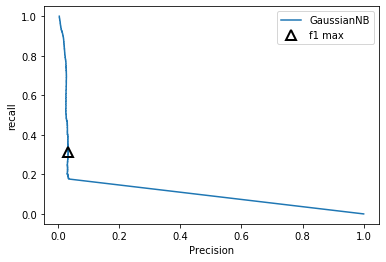

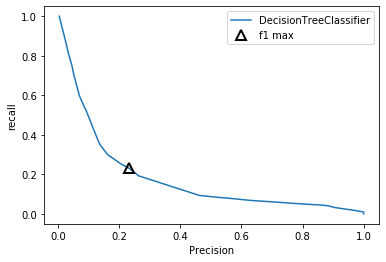

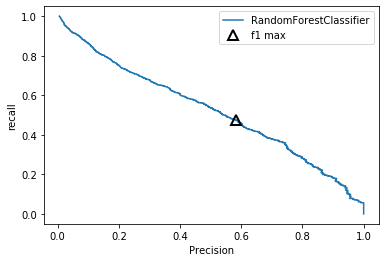

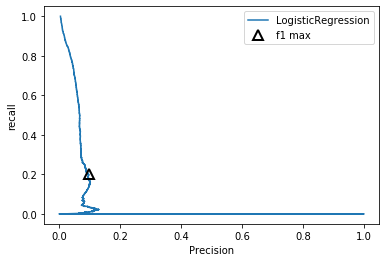

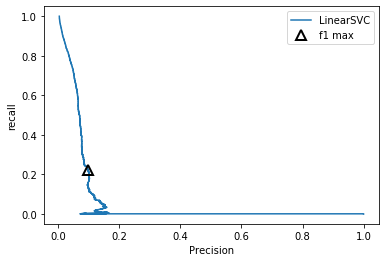

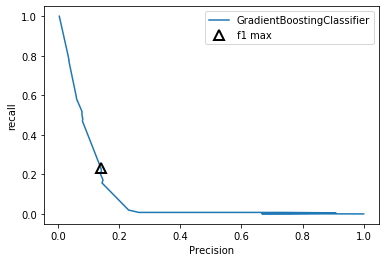

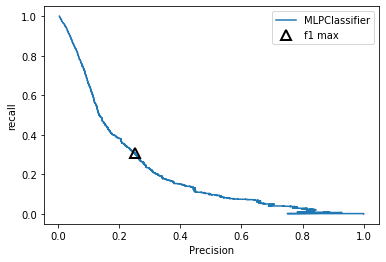

-------------------------------------------------------------------------------- 



In [31]:
print('Precision-recall curves with maximum f1-scoares, based on training data')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load(classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        precision, recall, thresholds = precision_recall_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate precision and recall curve')
    
    threshold_of_max = results.loc[results['classifier'] == classifier_string, ['f1_threshold']].iloc[0][0]
    close_max_threshold = np.argmin(np.abs(thresholds - threshold_of_max))
    
    plt.plot(precision, recall, label=classifier_string)
    plt.xlabel("Precision")
    plt.ylabel("recall")
    plt.plot(precision[close_max_threshold], recall[close_max_threshold], '^', markersize=10,
             label=("f1 max"), fillstyle="none", c='k', mew=2)
    plt.legend(loc= 'upper right')
    plt.show()
    
print(80 * "-", "\n")

ROC curves with max. Youden's J-statistic & max. f1-score, based on training data


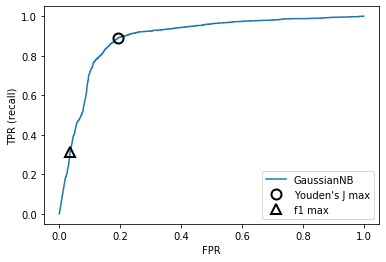

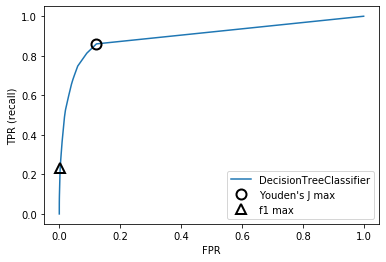

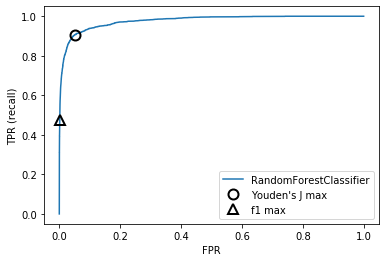

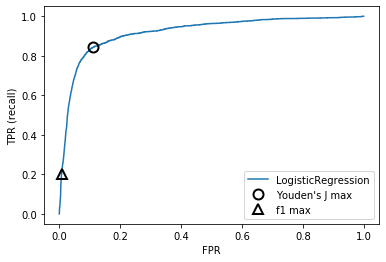

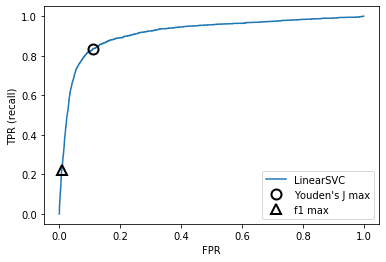

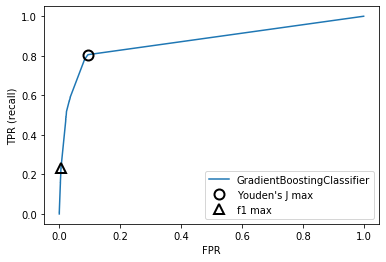

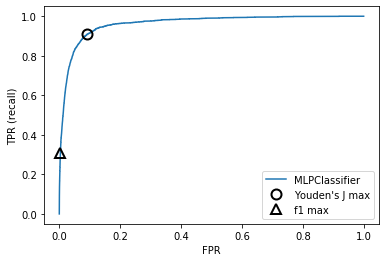

--------------------------------------------------------------------------------


In [32]:
# To highlight the difference between the two evaluation metrics, print ROC curves highlighting both the thresholds at which 
# the maximum Youden's J-statistic is obtained and the threshold at which the maximum f1-score is obtained
print('ROC curves with max. Youden\'s J-statistic & max. f1-score, based on training data')
for item in search_space:
    classifier_string = item[0]
    trained_classifier = joblib.load(classifier_string + '.pkl')
    
    if hasattr(trained_classifier, 'predict_proba'):
        predictions_of_best = trained_classifier.predict_proba(X_train)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    elif hasattr(trained_classifier, 'decision_function'):
        predictions_of_best = trained_classifier.decision_function(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, predictions_of_best)
    else: 
        print('Cannot calculate area under ROC curve')
        
    j_threshold_of_max = results.loc[results['classifier'] == classifier_string, ['j_threshold']].iloc[0][0]
    j_close_max_threshold = np.argmin(np.abs(thresholds - j_threshold_of_max))
    
    f1_threshold_of_max = results.loc[results['classifier'] == classifier_string, ['f1_threshold']].iloc[0][0]
    f1_close_max_threshold = np.argmin(np.abs(thresholds - f1_threshold_of_max))
    
    plt.plot(fpr, tpr, label=classifier_string)
    plt.plot(fpr[j_close_max_threshold], tpr[j_close_max_threshold], 'o', markersize=10,
             label=("Youden's J max"), fillstyle="none", c='k', mew=2)
    plt.plot(fpr[f1_close_max_threshold], tpr[f1_close_max_threshold], '^', markersize=10,
             label=("f1 max"), fillstyle="none", c='k', mew=2)
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.legend(loc= 'lower right')
    plt.show()
    
print(80 * "-")

# Some substantive predictions

In [33]:
# Examine the predicted probabilities of MIDs based on the classifier with the largest area under the ROC curve

roc_trained_classifier = joblib.load(top_ROC_classifier + '.pkl')
if hasattr(trained_classifier, 'predict_proba'):
    df['predictions_ROC_best'] = roc_trained_classifier.predict_proba(x_array)[:, 1]
elif hasattr(trained_classifier, 'decision_function'):
    df['predictions_ROC_best'] = roc_trained_classifier.decision_function(x_array)

In [34]:
# for the last year in the dataset (2009)
print(df[['year', 'stateabb_1', 'stateabb_2', 'predictions_ROC_best' ]].sort_values(by = ['predictions_ROC_best'], ascending=False).query('year==2009'))

print(80 * "-")

        year stateabb_1 stateabb_2  predictions_ROC_best
409804  2009        RUS        JPN              0.716667
134720  2009        COL        VEN              0.597529
386228  2009        TUR        GRC              0.588033
626841  2009        CHN        PHI              0.512074
606307  2009        ISR        LEB              0.472690
...      ...        ...        ...                   ...
238097  2009        URU        EQG              0.000102
108906  2009        URU        NIC              0.000076
99047   2009        URU        SAL              0.000076
53295   2009        URU        JAM              0.000076
476943  2009        BAH        MAA              0.000074

[12555 rows x 4 columns]
--------------------------------------------------------------------------------


Mean predictions of MID by year


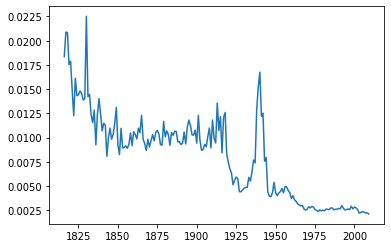

In [35]:
print('Mean predictions of MID by year')
plt.plot(df.groupby(['year'])['predictions_ROC_best'].mean())
plt.show()

Mean predictions of MID by year adjusting for the average capabilities of the two states in the dyad


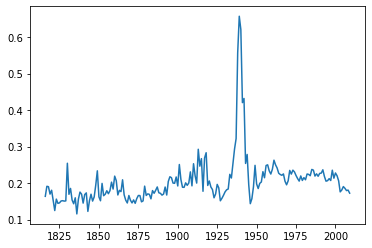

--------------------------------------------------------------------------------


In [36]:
print('Mean predictions of MID by year adjusting for the average capabilities of the two states in the dyad')
plt.plot(df.groupby(['year'])['predictions_ROC_best'].mean() / (df.groupby(['year'])['cinc_1'].mean() + df.groupby(['year'])['cinc_2'].mean()))
plt.show()
print(80 * "-")

In [37]:
# save results of best to file
results.to_csv('results.csv', index = False)

In [38]:
results

,classifier,parameter_grid,processed,best_parameter,test_score,mean_crossVal_score,mean_crossVal_fit_time,mean_crossVal_score_time,best_estimator_settings_all,evaluation_metric,j_threshold,j_max_train,j_max_test,f1_threshold,f1_max_train,f1_max_test
0,GaussianNB,{},True,{},0.885231,0.892295,0.462546,0.339534,"GaussianNB(priors=None, var_smoothing=1e-09)",roc_auc,2.40916e-08,0.697795,0.684104,0.999997,0.0597429,0.0570086
1,DecisionTreeClassifier,"{'max_depth': [4, 6, 8, 12, 14, 16, 18]}",True,{'max_depth': 6},0.880003,0.903434,3.248325,0.155516,"DecisionTreeClassifier(class_weight=None, crit...",roc_auc,0.00571166,0.738102,0.711432,0.134615,0.231687,0.178457
2,RandomForestClassifier,"{'max_depth': [4, 6, 8, 12]}",True,{'max_depth': 12},0.952418,0.948244,8.399840,0.421542,"RandomForestClassifier(bootstrap=True, class_w...",roc_auc,0.0122957,0.856377,0.75428,0.150002,0.524093,0.26087
3,LogisticRegression,"{'C': [0.001, 0.01, 0.1, 1, 10, 100]}",True,{'C': 0.1},0.907723,0.918104,1.915192,0.186519,"LogisticRegression(C=0.1, class_weight=None, d...",roc_auc,0.00331871,0.732979,0.698904,0.0653577,0.129893,0.122554
4,LinearSVC,"{'C': [0.001, 1, 100]}",True,{'C': 1},0.905424,0.913861,21.926692,0.184519,"LinearSVC(C=1, class_weight=None, dual=True, f...",roc_auc,-0.986037,0.72474,0.69227,-0.867474,0.137382,0.130456
5,GradientBoostingClassifier,"{'learning_rate': [0.001, 1, 100]}",True,{'learning_rate': 0.001},0.870072,0.864564,139.706901,0.676000,GradientBoostingClassifier(criterion='friedman...,roc_auc,0.00372191,0.711389,0.705269,0.0095581,0.174428,0.152572
6,MLPClassifier,"{'hidden_layer_sizes': [[100, 100], [30, 30, 3...",True,"{'hidden_layer_sizes': [60, 20, 10]}",0.950321,0.947070,122.578500,2.915000,"MLPClassifier(activation='relu', alpha=0.0001,...",roc_auc,0.00457271,0.817901,0.768378,0.11062,0.277493,0.230769
